In [1]:
import json
import pandas as pd
#import reddit api query script
from RedditAnalyzer.data.get_data import RedditScraper
from RedditAnalyzer.topics.analyze_text import CreateTopicModel
from RedditAnalyzer.topics.visualizations import plot_bar_charts, plot_wordclouds

#read app info
with open('reddit_app.json') as rd_f:
    data = json.load(rd_f)

Extract Data from Reddit

In [2]:
#subreddit to create topic model for
subreddit = 'Pokemon'

#log into to reddit api and custom scraper using app credentials
reddit = RedditScraper(client_id=data['client'], client_secret=data['secret'], user_agent=data['user'])

In [3]:
#use custom scraper and subreddit posts function to query from channel
top_week = reddit.subreddit_posts(subreddit, time_filt='week', with_comments=False)
top_week[:2]

Display Name: Pokemon
Title: Pokémon: Gotta Catch 'Em All!
Posts: 723 | Comments: 0


,text,uid,score,pid,created,parent
0,Many faces of Diglett.,18z68bq,14775,18z68bq,1.704459e+09,1
1,The plot of Scarlet & Violet is absolutely wil...,191kij2,7868,191kij2,1.704718e+09,1


In [4]:
#use custom scraper and subreddit posts function to query from channel
top_month = reddit.subreddit_posts(subreddit, time_filt='month', with_comments=False)

#remove posts that are also in top_week
top_month = top_month.loc[~top_month['pid'].isin(top_week['pid'].tolist())].reset_index(drop=True)
top_month[:2]

Display Name: Pokemon
Title: Pokémon: Gotta Catch 'Em All!
Posts: 1,000 | Comments: 0


,text,uid,score,pid,created,parent
0,these pokemon will always come back to you [OC].,18l8z0c,15836,18l8z0c,1.702907e+09,1
1,Best Pokeballs to use depending on the turn!.,18oi9gz,11231,18oi9gz,1.703261e+09,1


Visualizations

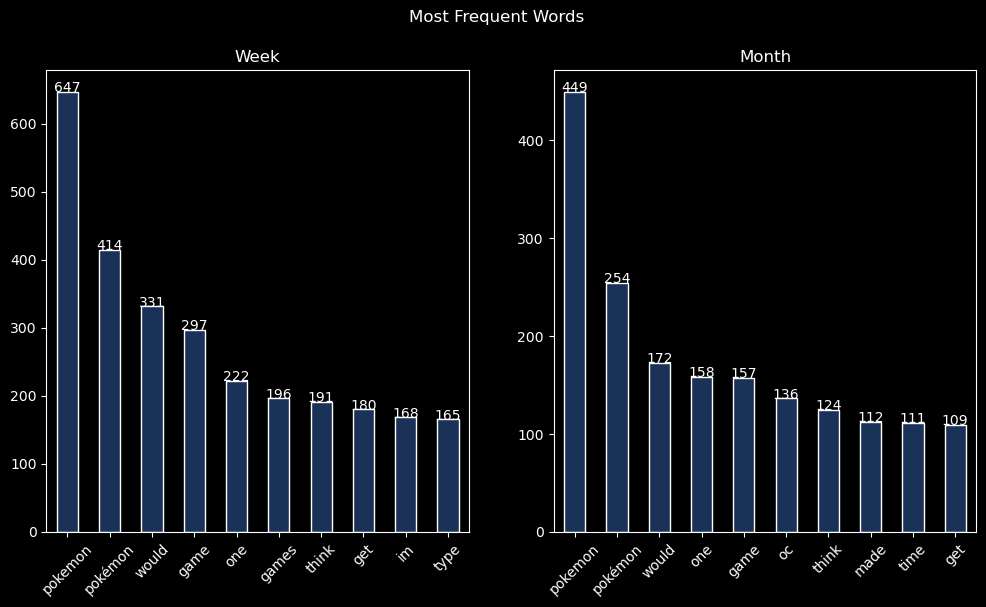

In [5]:
plot_bar_charts(top_week['text'], top_month['text'], 'Week', 'Month', 'Most Frequent Words')

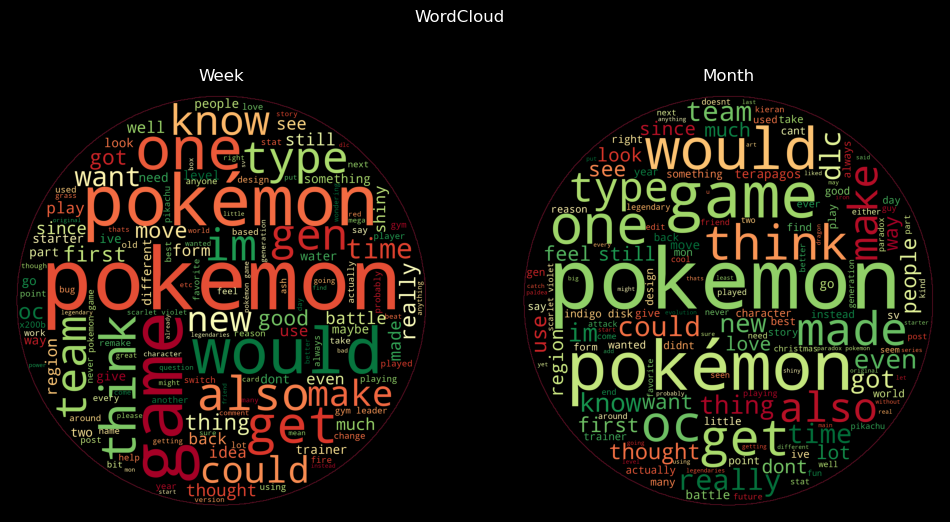

In [6]:
plot_wordclouds(top_week['text'], top_month['text'], 'Week', 'Month', 'WordCloud')

Topic Model

In [7]:
#total trials for optuna to iterate through
num_trials = 60

#instantiate topic modeling class for weekly data
topic_modeler = CreateTopicModel(df=top_week, column_name='text', use_hdbscan=False)

#create topic model for dataset and tune hyperparameters of model
topics, topic_model = topic_modeler.find_hyperparams(num_trials=num_trials)
#show topic labels
print(topic_model.generate_topic_labels())
topics.groupby('topic').agg({'text': len}).T

['0_oc_oc oc_day', '1_oc_pikachu_art', '2_game_like_pokemon', '3_nickname_paradox_thought', '4_game_games_pokémon', '5_squirtle_tattoo_design', '6_shiny_gen_starters', '7_pokémon_make_pokemon', '8_type_form_pokémon', '9_pokemon_ash_pokémon', '10_drawing_monotypes_comic', '11_team_type_moves', '12_pokemon_games_dex', '13_gen_best_people', '14_card_pokemon_cards', '15_dragon_year_year dragon', '16_pokemon_song_pokémon', '17_pokemon_psyduck_concierge']


topic,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
text,61,51,45,41,41,38,35,34,34,31,31,30,26,25,25,25,23,23


In [8]:
#instantiate topic modeling class for monthly data
topic_modeler = CreateTopicModel(df=top_month, column_name='text', use_hdbscan=False)

#create topic model for dataset and tune hyperparameters of model
topics_m, topic_model_m = topic_modeler.find_hyperparams(num_trials=num_trials)
#show topic labels
print(topic_model_m.generate_topic_labels())
topics_m.groupby('topic').agg({'text': len}).T

['0_pokemon_pokémon_type', '1_oc_oc oc_oc paras', '2_pokemon_pokémon_drawing', '3_art_fanart_drew', '4_game_pokemon_pokémon', '5_christmas_tattoo_crocheted', '6_pokemon_oc_know', '7_christmas_happy_new year', '8_pokemon_fusing gen_fusing', '9_paradox_oc_indigo', '10_trend_art_bored']


topic,0,1,2,3,4,5,6,7,8,9,10
text,95,80,78,76,73,72,69,50,48,46,42


Create Titles and Summaries for Topics

In [41]:
##### To-Do: Use page rank to sort posts by most important to least important

In [9]:
#groupby topic and create a list of all posts
df_w = topics.groupby('topic', as_index=False).agg({'text': list})
#get keywords for each topic
df_w['key_words'] = [
    [word[0] for word in topic_model.get_topic(i)][:6] for i in range(len(topic_model.generate_topic_labels()))
]


#do the same for the month topic model
df_m = topics_m.groupby('topic', as_index=False).agg({'text': list})
#keywords
df_m['key_words'] = [
    [word[0] for word in topic_model_m.get_topic(i)][:6] for i in range(len(topic_model_m.generate_topic_labels()))
]
df_w[:2]

,topic,text,key_words
0,0,"[Many faces of Diglett., The plot of Scarlet &...","[oc, oc oc, day, oc day, eevee, love]"
1,1,"[Pokemon villain memes I did while ago [OC]., ...","[oc, pikachu, art, fanart, drawing, paint]"


In [32]:
import os
from openai import OpenAI

with open('../keys/open-ai.json') as rd_f:
    ai = json.load(rd_f)

#set log-in info for openai
os.environ['OPENAI_API_KEY'] = ai['OPENAI_API_KEY']

#instantiate openai model
client = OpenAI()

In [51]:
#create prompts for each topic and dataframe
for dataframe in [df_w, df_m]:
    #prompt to create representative title
    dataframe['title_prompt'] = [f"""
    You are tasked with creating a readable and understandable topic title to represent the posts of users from the {subreddit} sub-reddit. 
    The title you create should be less than six words in length.

    For the following Reddit posts and key words; read and analyze each post and key word provided, think about the most important information,
    then create a topic title that represents the information in the posts and key words using the thought process below.

    Each Reddit posts is separated by the string "-----"

    POSTS: {"-----".join(post)[:13000]}
    TOPIC KEYWORDS: {key_words}

    Thought Process:
    1. Read and analyze the entire text, focusing on the most important parts of the posts.
    2. Answer the question "What is the main topic of discussion within these posts?" as concisely and completely as possible.
    3. Create a topic title that is only a few words long and will help readers understand the items discussed by the posts and keywords.
    4. Make sure your answers are accurate to the input text and do not make up information.
    5. Do not make up information or you will be penalized.
    6. You should only create one title.

    The output should be a short but concise title no longer than six words.
    """ for post, key_words in zip(dataframe['text'], dataframe['key_words'])]

    #prompt to create summary of posts within topic
    dataframe['summary_prompt'] = [f"""
    You are tasked with reading the posts from within the {subreddit} sub-reddit and summarizing the information into an informative and descriptive
    summary. Your summary should represent the main topic of discussion by the users and their Reddit posts.

    For the following Reddit posts, read and analyze every post, think about the most important information then create an accurate and representative
    summary of the information.

    Each Reddit posts is separated by the string "-----"

    POSTS: {"-----".join(posts)[:13000]}

    To create the summary, please follow the following thought process.

    Thought Process:
    1. Read and analyze the entire text, focusing on the most important parts of the posts.
    2. Answer the question "What are the users within these posts discussing?" as concisely and completely as possible.
    3. Create a summary that will help readers understand the items discussed by the posts.
    4. The summary should include details regarding what the users are discussing in their posts.
    5. Make sure your answers are accurate to the input text and do not make up information.
    6. Do not make up information or you will be penalized.
    7. Do not repeat information.

    Your summary output should be no more than 4 sentences.
    """ for posts in dataframe['text']]
    
df_w[:2]

,topic,text,key_words,title_prompt,summary_prompt,title,summary
0,0,"[Many faces of Diglett., The plot of Scarlet &...","[oc, oc oc, day, oc day, eevee, love]",\n You are tasked with creating a readable ...,\n You are tasked with reading the posts fr...,The Many Faces of Diglett,The Reddit posts in the Pokemon sub-reddit cov...
1,1,"[Pokemon villain memes I did while ago [OC]., ...","[oc, pikachu, art, fanart, drawing, paint]",\n You are tasked with creating a readable ...,\n You are tasked with reading the posts fr...,"""Pokemon Fanart and Drawings Compilation""",The users in the Pokemon sub-reddit are discus...


In [52]:
#check prompt text length
pd.DataFrame(df_w['summary_prompt'].apply(lambda text: len(text))).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
summary_prompt,4068,5043,14259,8122,14259,4504,12489,12712,14259,14259,5491,14259,13468,12920,8580,3427,8645,6936


In [53]:
#check prompt token length
pd.DataFrame(df_w['summary_prompt'].apply(lambda text: len(text.split()))).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17
summary_prompt,532,757,2486,1339,2549,712,2114,2110,2408,2357,902,2479,2472,2311,1532,563,1447,1108


In [54]:
def generate_completion(prompt, model="gpt-3.5-turbo"):
    #send prompt to openai api
    response = client.chat.completions.create(
        model=model,
        messages=[
            {
                "role": "user",
                "content": prompt
            }],
        temperature=0.4,
        top_p=1
    )
    output = response.choices[0].message.content
    return output

Weekly Topics

In [55]:
#generate topic titles
df_w['title'] = [generate_completion(prompt) for prompt in df_w['title_prompt']]

#generate topic summaries
df_w['summary'] = [generate_completion(prompt) for prompt in df_w['summary_prompt']]

In [68]:
for i in range(len(df_w)):
    print(f"Topic {i}: {df_w['title'][i]}\n\n")
    print(f"Summary: {df_w['summary'][i]}\n\n")
    print('*'*100)

Topic 0: Love for OC Eevee and more


Summary: The users in the Pokemon sub-reddit are discussing various topics related to the Pokemon franchise. These topics include sharing original content such as artwork and character designs, discussing the plot of a game called Scarlet & Violet, and expressing opinions about different Pokemon and their evolutions. Overall, the posts cover a wide range of subjects within the Pokemon community.


****************************************************************************************************
Topic 1: Pokemon OC Art and Fanart


Summary: The users in the Pokemon sub-reddit are discussing and sharing various forms of Pokemon fan art. The posts include drawings, sketches, animations, and pixel art of different Pokemon characters. Some posts also mention specific art styles or techniques used in creating the artwork. Overall, the main topic of discussion revolves around the creativity and talent of the artists in the Pokemon community.


*********

Monthly Topics

In [69]:
#generate topic titles
df_m['title'] = [generate_completion(prompt) for prompt in df_m['title_prompt']]

#generate topic summaries
df_m['summary'] = [generate_completion(prompt) for prompt in df_m['summary_prompt']]

In [71]:
for i in range(len(df_m)):
    print(f"Topic {i}: {df_m['title'][i]}\n\n")
    print(f"Summary: {df_m['summary'][i]}\n\n")
    print('*'*100)

Topic 0: Pokemon Subreddit Discussions: Types, Evolution, Creepy


Summary: The Reddit posts in the Pokemon sub-reddit cover a range of topics. Users discuss the best Pokeballs to use depending on the turn, the creepy evolution process of Rockruff, the redundancy of Appletun and Flapple compared to Hydrapple, the addition of a new type in the 10th Generation, the forgotten elemental monkeys, and the programming of level up moves for evolved Pokemon. They also talk about their least favorite Pokemon, the character arc of Kieran, their favorite Pokemon if they could only have three, and the existence of Psychic people and Ghost Pokemon in the Pokemon world.


****************************************************************************************************
Topic 1: Pokemon OC Posts and Discussions


Summary: The users in the Pokemon sub-reddit are discussing various topics related to Pokemon. These topics include sharing original artwork, discussing Pokemon designs and sizes, sharing f

Compare Topics

In [72]:
from scipy.spatial.distance import cosine
from sentence_transformers import SentenceTransformer

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')

#cosine similarity function
def cosine_sim(x, y):
    return 1 - cosine(x, y)

In [85]:
#encode keywords for each topic and then take the average of the embeddings
df_w['keyword_encoding'] = [model.encode(top).mean(axis=0) for top in df_w['key_words']]
df_m['keyword_encoding'] = [model.encode(top).mean(axis=0) for top in df_m['key_words']]

#compare week topics to month topics
high_sim = []
for x in range(len(df_w)):
    for y in range(len(df_m)):
        sim = cosine_sim(df_w['keyword_encoding'][x], df_m['keyword_encoding'][y])
        if sim > 0.825:
            high_sim.append((x, y, sim))

Repeat Topics This Week

In [86]:
#save high similarity topics into dataframe
sim_df = pd.DataFrame([(
    df_w['title'][sim[0]], df_m['title'][sim[1]], sim[2]) for sim in high_sim], columns=['topic_week', 'topic_month', 'sim'])
sim_df

,topic_week,topic_month,sim
0,Pokemon OC Art and Fanart,Pokemon Fanart and Artwork Showcase,0.910404
1,Adult Character Ideas for Pokemon Game,"Pokemon Subreddit Discussions: Types, Evolutio...",0.848720
2,Adult Character Ideas for Pokemon Game,Pokemon Art and Discussions,0.827951
3,Adult Character Ideas for Pokemon Game,Pokemon Sub-Reddit Discussions: Game Analysis,0.958201
4,"Pokemon Games: Preferences, Recommendations, a...",Pokemon Sub-Reddit Discussions: Game Analysis,0.870098
5,"Pokemon Art, Designs, and Discussions",Pokemon Art and Discussions,0.836326
6,Legendary BST and Mega Evolution Wishlist,"Pokemon Subreddit Discussions: Types, Evolutio...",0.840456
7,Bad Decisions and Anime Moments,"Pokemon Subreddit Discussions: Types, Evolutio...",0.843849
8,Bad Decisions and Anime Moments,Pokemon Art and Discussions,0.838282
9,Bad Decisions and Anime Moments,Pokemon Sub-Reddit Discussions: Game Analysis,0.829627


In [87]:
print(set(sim_df['topic_week']))

{'Bad Decisions and Anime Moments', 'Pokemon Art, Designs, and Discussions', 'Pokemon Games: Preferences, Recommendations, and Remakes', 'Adult Character Ideas for Pokemon Game', 'Pokemon: Sounds, Songs, and Fan Opinions', 'Legendary BST and Mega Evolution Wishlist', 'Pokemon OC Art and Fanart'}


New Topics This Week

In [89]:
#topics that were represented in the month and week dataset
repeat_topics = set([tup[0] for tup in high_sim])

#topics that are new in the most recent dataset
new_topics = set([top for top in topics['topic'].unique() if top not in repeat_topics])
new_topic_labels = [df_w['title'][top] for top in new_topics]
print(new_topic_labels)

['Love for OC Eevee and more', 'Pokémon Nicknames and Ancient Egypt', 'Squirtle designs, tattoos, and crocheted creations.', 'Shiny Gen Starters and Berry Forms', 'User Art and Comic Discussions', 'Team Building and Moves Help', 'Pokemon Games, Dex, and Trade Discussions', 'Opinions on Pokemon Generations and Games', 'Pokemon Cards and Collectibles Discussion', 'Favorite Dragon Pokemon for Year', 'Pokémon Concierge and Psyduck Discussion']
